In [ ]:
# 导入必要的库
# 导入基础库
import numpy as np
import tqdm
from tqdm import tqdm
import random
from collections import namedtuple
import sys
# 导入pytorch库
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# 导入图像处理库
import timm
# 导入绘图库
import matplotlib.pyplot as plt
import pyvista as pv
pv.set_jupyter_backend('client')
# # 导入julia
import julia
from julia import Main as env
env.include("environment03.jl")

<PyCall.jlwrap step>

In [4]:
## 定义网络常数
LOG_STD_MAX = 2     # 最大标准差
LOG_STD_MIN = -20   # 最小标准差

## 自定义特征提取器
class StateFeatureExtractor(nn.Module):
    '''
    特征提取器, 从state中提取特征向量, 并作为动作价值函数以及策略函数的输入
    out_channels: 输出通道数
    gm_size: global_map的形状。gm_size = [通道数，维度，维度，维度]
    lm_size: local_map的形状。lm_size = [通道数，维度，维度]
    cs_size: cs的形状(cs是一个向量)。cs_size = 维度
    gm_output_dim: self.gm_extractor的输出维度
    '''
    def __init__(self, gm_out_channels, lm_out_channels, gm_size, lm_size, cs_size, gm_output_dim = 128, lm_output_dim = 512, cs_output_dim = 16, output_dim = 512):
        super(StateFeatureExtractor, self).__init__()

        self.gm_in_channels = gm_size[0]    # global_map通道数
        self.lm_in_channels = lm_size[0]    # local_map通道数
        self.gm_volume = gm_size[1] * gm_size[2] * gm_size[3]   # global_map通道维度之外的三个维度的形状
        self.lm_area = lm_size[1] * lm_size[2]  # local_map通道维度之外的两个维度的形状
        self.gm_out_channels = gm_out_channels    # global_map输出通道数
        self.lm_out_channels = lm_out_channels  # local_map输出通道数
        self.cs_dim = cs_size       # cs(刀具位置和姿态)的维度
        self.gm_output_dim = gm_output_dim  # self.gm_extractor的输出维度
        self.lm_output_dim = lm_output_dim  # self.lm_extractor的输出维度
        self.cs_output_dim = cs_output_dim  # self.cs_extractor的输出维度
        self.output_dim = output_dim        # self.collective_extractor的输出维度

        #! 定义global_map特征提取卷积层
        self.gm_extractor = nn.Sequential(
            nn.Conv3d(in_channels=self.gm_in_channels, out_channels=self.gm_out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv3d(in_channels=self.gm_out_channels, out_channels=self.gm_out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=self.gm_out_channels * self.gm_volume, out_features=self.gm_output_dim),
            nn.ReLU()
        )

        #! 定义local_map特征提取卷积层
        self.lm_extractor = nn.Sequential(
            nn.Conv2d(in_channels=self.lm_in_channels, out_channels=self.lm_out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=self.lm_out_channels, out_channels=self.lm_out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(self.lm_out_channels * self.lm_area, self.lm_output_dim),
            nn.ReLU()
        )

        #! 定义cs特征提取层
        self.cs_extractor = nn.Sequential(
            nn.Linear(self.cs_dim, self.cs_output_dim),
            nn.ReLU()
        )

        #! 整合三个特征提取层
        self.collective_extractor = nn.Sequential(
            nn.Linear(self.gm_output_dim + self.lm_output_dim + self.cs_output_dim, self.output_dim),
            nn.ReLU(),
        )

    def forward(self, x):
        gm = x[0]
        lm = x[1]
        cs = x[2]
        gm = self.gm_extractor(gm)
        lm = self.lm_extractor(lm)
        cs = self.cs_extractor(cs)
        x = torch.cat((gm, lm, cs), dim=1)
        x = self.collective_extractor(x)
        return x
    

## 自定义动作价值函数
class QNetWork(nn.Module):
    '''
    动作价值函数, 根据状态(state)输入和动作(action)输入, 输出动作价值
    if_feature_extractor: 是否使用特征提取器。True: 使用特征提取器, False: 不使用特征提取器。默认不使用特征提取器
    state_dim: 状态维度。如果采用特征提取器, 则特征提取器的输出维度output_dim=state_dim
    action_dim: 动作维度。action_dim = [x位置变化, y位置变化, z位置变化, theta角度变化, phi角度变化, 主轴转速的变化, 进给速度的变化]
    output_dim: 输出维度, 固定为1, 输出奖励值
    feature_dim1: 第一个隐藏层维度
    feature_dim2: 第二个隐藏层维度
    '''
    def __init__(self, if_feature_extractor = True, features_extractor: StateFeatureExtractor = None, state_dim = 512, action_dim = 7, output_dim = 1, hidden_dim1 = 256, hidden_dim2 = 128):
        super(QNetWork, self).__init__()

        self.if_feature_extractor = if_feature_extractor
        self.features_extractor = features_extractor
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.output_dim = output_dim
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2

        #! Q值网络
        self.q_network = nn.Sequential(
            nn.Linear(self.state_dim + self.action_dim, self.hidden_dim1),
            nn.ReLU(),
            nn.Linear(self.hidden_dim1, self.hidden_dim2),
            nn.ReLU(),
            nn.Linear(self.hidden_dim2, self.output_dim)
        )

    def forward(self, state, action):
        if self.if_feature_extractor:   # 采用特征提取器, 将state转换成特征向量state
            #* 动作价值函数与策略函数共用一个特征提取器
            with torch.no_grad():
                state = self.features_extractor(state)
        x = torch.cat([state, action], dim=1)
        x = self.q_network(x)
        return x


## 自定义策略函数
class PolicyNetWork(nn.Module):
    '''
    策略函数, 根据状态(state)输入, 输出动作(action)概率
    if_feature_extractor: 是否使用特征提取器。True: 使用特征提取器, False: 不使用特征提取器。默认不使用特征提取器
    state_dim: 状态维度
    action_dim: 动作维度
    feature_dim1: 第一个隐藏层维度
    feature_dim2: 第二个隐藏层维度
    '''
    def __init__(self, if_feature_extractor = True, features_extractor: StateFeatureExtractor = None, state_dim = 512, action_dim = 7, hidden_dim = 256, output_dim = 128):
        super(PolicyNetWork, self).__init__()

        self.if_feature_extractor = if_feature_extractor
        self.features_extractor = features_extractor
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        #! 策略网络
        self.policy_dist = nn.Sequential(
            nn.Linear(self.state_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.output_dim),
            nn.ReLU()
        )

        #! 输出均值和标准差
        # TODO：https://arxiv.org/abs/2005.05719 提出一种根据状态的采样策略，可以尝试使用
        self.log_std = nn.Linear(self.output_dim, self.action_dim)
        self.mu = nn.Linear(self.output_dim, self.action_dim)

    def forward(self, state):
        '''
        前向传播
        '''
        # 0. 特征提取器提取特征
        if self.if_feature_extractor:
            state = self.features_extractor(state)
        # 1. 通过policy网络得到log_std和mu
        x = self.policy_dist(state)
        mu = self.mu(x)
        log_std = self.log_std(x)
        log_std = torch.clamp(log_std, LOG_STD_MIN, LOG_STD_MAX)    # 限制log_std的范围
        std = torch.exp(log_std)    # 得到真正的标准差
        # 2. 通过std和mu创建高斯分布
        dist = torch.distributions.Normal(mu, std)
        # 3. 从高斯分布中取样得到动作
        u = dist.rsample()
        action = torch.tanh(u)  # 将动作限制在[-1， 1]之间
        # 4. 计算动作分布的标准差并返回对数标准差的和
        log_prob = dist.log_prob(u)
        log_prob -= torch.log(1 - action ** 2 + 1e-6)
        log_prob = log_prob.sum(1, keepdim=True)
        return action, log_prob
    
    def get_action(self, state):
        '''
        采样动作
        '''
        # 0. 特征提取器提取特征
        if self.if_feature_extractor:
            state = self.features_extractor(state)
        # 1. 通过policy网络得到log_std和mu
        x = self.policy_dist(state)
        mu = self.mu(x)
        return torch.tanh(mu)

In [5]:
## 经验回放缓冲区
# TODO: 优化经验回放缓冲区
Transition = namedtuple('Transition',
                        ('state','reward', 'done', 'action', 'next_state'))

#// class Memory:
#//     def __init__(self, memory_size):
#//         self.memory_size = memory_size
#//         self.memory = []
#//     def add(self, *transition):
#//         self.memory.append(Transition(*transition))
#//         if len(self.memory) > self.memory_size:
#//             self.memory.pop(0)
#//         assert len(self.memory) <= self.memory_size
#//     def sample(self, batch_size = 256):
#//         return random.sample(self.memory, batch_size)
#//     def __len__(self):
#//         return len(self.memory)

class ReplayBuffer:
    '''
    经验回放缓冲区
    memory_size: 缓冲区大小
    batch_size: 批次大小
    '''
    def __init__(self, memory_size = 1000000, batch_size = 256):
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.memory = []

    def add(self, state, reward, done, action, next_state):
        self.memory.append(Transition(state, reward, done, action, next_state))
        if len(self.memory) > self.memory_size:
            self.memory.pop(0)
        assert len(self.memory) <= self.memory_size

    def sample(self):
        return random.sample(self.memory, self.batch_size)
    
    def __len__(self):
        return len(self.memory)

In [6]:
## SAC算法
class SAC:
    '''
    learning_rate: 学习率
    tau: 软更新参数
    gamma: 折扣因子
    buffer_size: 经验回放缓冲区大小
    batch_size: 训练batch大小
    if_feature_extractor: 是否使用特征提取器
    gm_out_channels: global_map输出通道数
    lm_out_channels: local_map输出通道数
    gm_size: global_map的形状。gm_size = [通道数，维度，维度，维度]
    lm_size: local_map的形状。lm_size = [通道数，维度，维度]
    cs_size: cs的形状(cs是一个向量)。cs_size = 维度
    gm_output_dim: self.gm_extractor的输出维度
    lm_output_dim: self.lm_extractor的输出维度
    cs_output_dim: self.cs_extractor的输出维度
    features_dim: 特征提取器的输出维度
    action_dim: 动作维度
    q_hidden_dim1: Q网络第一个隐藏层维度
    q_hidden_dim2: Q网络第二个隐藏层维度
    p_hidden_dim1: 策略网络第一个隐藏层维度
    p_hidden_dim2: 策略网络第二个隐藏层维度
    ent_coef: 熵系数
    '''
    def __init__(
            self,
            env,
            learning_rate = 0.003,
            tau = 0.005,
            gamma = 0.99,
            buffer_size = 1000000,
            batch_size = 256,
            if_feature_extractor = False,
            gm_out_channels = 2,
            lm_out_channels = 18,
            gm_size = [2, 10, 10, 10],
            lm_size = [18, 75, 75],
            cs_size = 9,
            gm_output_dim = 128,
            lm_output_dim = 512,
            cs_output_dim = 16,
            features_dim = 512,
            action_dim = 7,
            q_hidden_dim1 = 256,
            q_hidden_dim2 = 128,
            p_hidden_dim1 = 256,
            p_hidden_dim2 = 128,
            ent_coef = 0.1
    ):
        self.env = env
        self.learning_rate = learning_rate
        self.tau = tau
        self.gamma = gamma
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.if_feature_extractor = if_feature_extractor
        self.features_dim = features_dim    # 特征提取器的输出维度，同时也是Q网络和策略网络的状态输入维度
        self.action_dim = action_dim        # 动作维度
        self.q_hidden_dim1 = q_hidden_dim1  # Q网络第一个隐藏层维度
        self.q_hidden_dim2 = q_hidden_dim2
        self.p_hidden_dim1 = p_hidden_dim1
        self.p_hidden_dim2 = p_hidden_dim2
        self.target_entropy = -self.action_dim  # 目标熵
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # 使用特征提取器
        if if_feature_extractor:
            self.gm_out_channels = gm_out_channels
            self.lm_out_channels = lm_out_channels
            self.gm_size = gm_size
            self.lm_size = lm_size
            self.cs_size = cs_size
            self.gm_output_dim = gm_output_dim
            self.lm_output_dim = lm_output_dim
            self.cs_output_dim = cs_output_dim
            self.features_extractor = StateFeatureExtractor(gm_output_channels=self.gm_out_channels, lm_out_channels=self.lm_out_channels, 
                                                            gm_size=self.gm_size, lm_size=self.lm_size, cs_size=self.cs_size, 
                                                            gm_output_dim=self.gm_output_dim, lm_output_dim=self.lm_output_dim, cs_output_dim=self.cs_output_dim, output_dim=self.features_dim).to(self.device)
        else:
            self.features_extractor = None

        # 定义Q网络
        self.q1 = QNetWork(if_feature_extractor=self.if_feature_extractor, features_extractor=self.features_extractor, 
                      state_dim=self.features_dim, action_dim=self.action_dim, hidden_dim1=self.q_hidden_dim1, hidden_dim2=self.q_hidden_dim2).to(self.device)
        self.q2 = QNetWork(if_feature_extractor=self.if_feature_extractor, features_extractor=self.features_extractor,
                      state_dim=self.features_dim, action_dim=self.action_dim, hidden_dim1=self.q_hidden_dim1, hidden_dim2=self.q_hidden_dim2).to(self.device)
        self.q1_target = QNetWork(if_feature_extractor=self.if_feature_extractor, features_extractor=self.features_extractor,
                             state_dim=self.features_dim, action_dim=self.action_dim, hidden_dim1=self.q_hidden_dim1, hidden_dim2=self.q_hidden_dim2).to(self.device)
        self.q2_target = QNetWork(if_feature_extractor=self.if_feature_extractor, features_extractor=self.features_extractor,
                             state_dim=self.features_dim, action_dim=self.action_dim, hidden_dim1=self.q_hidden_dim1, hidden_dim2=self.q_hidden_dim2).to(self.device)
        self.q1_opt = optim.Adam(self.q1.parameters(), lr=self.learning_rate)   # 定义Q网络优化器
        self.q2_opt = optim.Adam(self.q2.parameters(), lr=self.learning_rate)   # 定义Q网络优化器

        # 定义策略网络
        self.policy_net = PolicyNetWork(state_dim=self.features_dim, action_dim=self.action_dim, 
                                        if_feature_extractor=self.if_feature_extractor, 
                                        hidden_dim=self.p_hidden_dim1, output_dim=self.p_hidden_dim2).to(self.device)
        if self.if_feature_extractor:   # 采用特征提取器, 则策略网络和特征提取器共同训练
            self.policy_opt = optim.Adam(list(self.features_extractor.parameters()) + list(self.policy_net.parameters()), lr=self.learning_rate)
        else:
            self.policy_opt = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)   # 定义策略网络优化器
        
        # 定义经验回放缓冲区
        self.replay_buffer = ReplayBuffer(self.buffer_size, self.batch_size)

        # 定义温度
        self.log_ent_coef = torch.tensor([0.0]).to(self.device).requires_grad_()
        self.ent_coef_opt = optim.Adam([self.log_ent_coef], lr=self.learning_rate)

    def choose_action(self, state):
        state = torch.FloatTensor([state]).to(self.device)
        action, _ = self.policy_net(state)
        return action.cpu().detach().numpy()
    
    def eval_action(self, state):
        state = torch.FloatTensor([state]).to(self.device)
        action = self.policy_net.get_action(state)
        return action.cpu().detach().numpy()

    def store(self, state, reward, done, action, next_state):
        state = torch.FloatTensor(state)
        reward = torch.Tensor([reward])
        done = torch.Tensor([done])
        action = np.array([action])
        action = torch.Tensor(action)
        next_state = torch.FloatTensor(next_state)
        self.replay_buffer.add(state, reward, done, action, next_state)

    def unpack(self, batch):
        batch = Transition(*zip(*batch))
        states = torch.cat(batch.state).view(self.batch_size, self.features_dim).to(self.device)
        rewards = torch.cat(batch.reward).view(self.batch_size, 1).to(self.device)
        dones = torch.cat(batch.done).view(self.batch_size, 1).to(self.device)
        actions = torch.cat(batch.action).view(-1, self.action_dim).to(self.device)
        next_states = torch.cat(batch.next_state).view(self.batch_size, self.features_dim).to(self.device)
        return states, rewards, dones, actions, next_states

    def train(self):
        '''
        训练函数
        '''
        # 0. 经验回放缓冲区中取样
        if len(self.replay_buffer) < self.batch_size:
            return
        batch = self.replay_buffer.sample()
        state, reward, done, action, next_state = self.unpack(batch)

        # 1. 策略网络根据state预测动作
        action_pi, log_prob = self.policy_net(state)
        # log_prob = log_prob.reshape(-1, 1) 

        # 2. 更新温度
        ent_coef = torch.exp(self.log_ent_coef.detach())
        ent_coef_loss = -(self.log_ent_coef * (log_prob + self.target_entropy).detach()).mean()
        self.ent_coef_opt.zero_grad()
        ent_coef_loss.backward()
        self.ent_coef_opt.step()
         
        # 3. 更新状态价值函数
        # 3.1 计算目标Q值target
        with torch.no_grad():   # 不更新q1_target和q2_target
            next_action, next_log_prob = self.policy_net(next_state)
            q1_target = self.q1_target(next_state, next_action)
            q2_target = self.q2_target(next_state, next_action)
            q_target = torch.min(q1_target, q2_target)
            #! 这里next_log_prob的维度可能出现问题
            target_q = reward + self.gamma * (1 - done) * (q_target - ent_coef * next_log_prob)

        # 3.2 计算q网络的当前q值current_q1, current_q2
        current_q1 = self.q1(state, action)
        current_q2 = self.q2(state, action)

        # 3.3 计算q网络的损失函数
        q1_loss = F.mse_loss(current_q1, target_q)
        q2_loss = F.mse_loss(current_q2, target_q)

        # 3.4 更新q网络
        self.q1_opt.zero_grad()
        q1_loss.backward()
        self.q1_opt.step()
        self.q2_opt.zero_grad()
        q2_loss.backward()
        self.q2_opt.step()

        # 4. 更新策略网络
        # 4.1 计算策略网络的损失函数
        q1 = self.q1(state, action_pi)
        q2 = self.q2(state, action_pi)
        q_min = torch.min(q1, q2)
        policy_loss = (ent_coef * log_prob - q_min).mean()

        # 4.2 更新策略网络
        self.policy_opt.zero_grad()
        policy_loss.backward()
        self.policy_opt.step()

        # 5. 软更新目标Q网络
        for param, target_param in zip(self.q1.parameters(), self.q1_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

In [7]:
# 定义参数
max_episodes = 500 # 迭代训练次数
max_steps = 100    # 每个回合的最大步数

# 创建对象
agent = SAC(env, features_dim=2, action_dim=1)
episode_rewards = []    # 只是用来看学习的成果的，和训练过程无关
episode_steps = []

# 开始迭代训练
for episode in tqdm(range(max_episodes), file=sys.stdout):
    # 重置环境并获取初始状态
    state = env.reset()
    # 初始化当前回合的奖励
    episode_reward = 0
    episode_step = 0
    # 循环惊醒每一步的操作
    for step in range(max_steps):
        # 根据当前状态选择动作
        action = agent.choose_action(state)
        next_state, reward, terminated, truncated = env.step(action)  # 与环境交互产生下一个状态并生成奖励等相关信息
        done = terminated or truncated
        # 存入经验回放缓冲区
        agent.store(state, reward, done, action, next_state)
        agent.train()
        episode_reward += reward
        episode_step += 1
        # 更新当前状态
        state = next_state
        if done:
            break
    # 记录当前回合的奖励
    episode_rewards.append(episode_reward)
    episode_steps.append(episode_step)

    if episode % 10 == 0:
        tqdm.write("Episode"+str(episode)+":"+str(episode_reward))
        tqdm.write("Episode"+str(episode)+":"+str(episode_step))

  0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\25808\AppData\Local\Temp\ipykernel_20540\1165126909.py:112: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  state = torch.FloatTensor([state]).to(self.device)


Episode0:-1.01                         
Episode0:1                             
Episode10:-1.01                                
Episode10:1                                    
Episode20:-1.0253968698438256                  
Episode20:25                                   
Episode30:-0.9928214842826129                   
Episode30:46                                    
Episode40:-0.9635016041994096                   
Episode40:3                                     
Episode50:-1.0186003492958844                   
Episode50:2                                     
Episode60:-1.01                                 
Episode60:1                                     
Episode70:-1.01                                 
Episode70:1                                     
Episode80:-1.01                                 
Episode80:1                                     
Episode90:0.046909764111042036                  
Episode90:73                                    
Episode100:0.575544047653675              

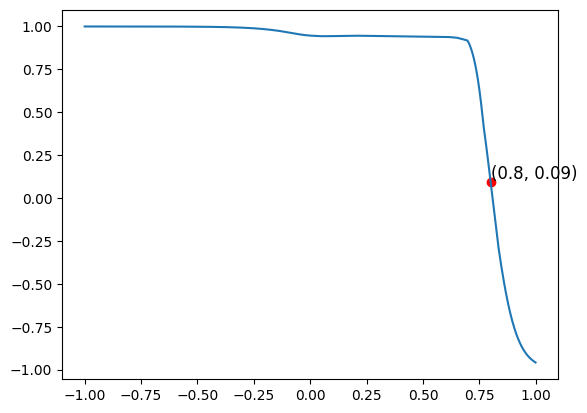

In [8]:
s_list = []
a_list = []
for i in range(2000):
    state = i / 1000 - 1
    action = agent.eval_action([state, state])
    s_list.append(state)
    a_list.append(action[0][0])

plt.plot(s_list, a_list)
index_0_8 = s_list.index(0.8)
a = a_list[index_0_8]
plt.scatter([0.8], [a], color='red')
plt.text(0.8, a, f'({0.8}, {a:.2f})', fontsize=12, verticalalignment='bottom')
plt.show()